This notebook is a continuation ofthe previous Part 1. In this notebook I'll resize the spectrograms and masks, and see how good/bad the resizing is before  finally formatting everything into a keras-friendly neural network.

In [1]:
import matplotlib.pyplot as plt 
plt.rcParams['agg.path.chunksize'] = 10000
import numpy as np 
import pickle
from skimage.transform import resize


In [2]:
# begin to put the files into pickles so that we can continue onto the next notebook!
with open("sound_spec_mask/round_2/test_round2.pkl", "rb") as test_file:
    testing = pickle.load(test_file)

with open(r'sound_spec_mask/round_2/training_round2.pkl','rb') as train_file:
    training = pickle.load(train_file)

with open(r'sound_spec_mask/round_2/validation_round2.pkl','rb') as validn_file:
    validation = pickle.load(validn_file)

    


In [3]:
%matplotlib notebook

In [4]:
# resize spectrogram into 128x128 images and save it into the same dictionary for each file name :

In [5]:
def make_128square_images(data_dict,mask_or_spec='specgms'):
    for one_case in data_dict.keys():
        for each_fft_resn in data_dict[one_case][mask_or_spec].keys():
            # add 0.128 to indicate that this is the 128 x 128 resized version of the X sized FFT
            # eg. if it's the 32 window FFT that's resized the key becomes 32.128
            small_img = np.copy(data_dict[one_case][mask_or_spec][each_fft_resn])
            data_dict[one_case][mask_or_spec][each_fft_resn+0.128] = resize(small_img, (128,128), preserve_range=True)
            
            
            if mask_or_spec is 'masks':
                threshold = np.percentile(data_dict[one_case][mask_or_spec][each_fft_resn+0.128].flatten(), 99)
                resized_mask = np.zeros(data_dict[one_case][mask_or_spec][each_fft_resn+0.128].shape)
                resized_mask[data_dict[one_case][mask_or_spec][each_fft_resn+0.128]>=threshold] = 1 
                data_dict[one_case][mask_or_spec][each_fft_resn+0.128] = np.copy(resized_mask)

            else:
                # normalise the image data to lie between 0 and 1.
                data_dict[one_case][mask_or_spec][each_fft_resn+0.128] *= 1.0/np.max(data_dict[one_case][mask_or_spec][each_fft_resn+0.128])
            # reshape to make it keras friendly
            data_dict[one_case][mask_or_spec][each_fft_resn+0.128] = data_dict[one_case][mask_or_spec][each_fft_resn+0.128].reshape(128,128,1)
            
        
                
                
        


In [6]:
for spec_and_mask in ['masks', 'specgms']:
    make_128square_images(testing,spec_and_mask)
    make_128square_images(training,spec_and_mask)
    make_128square_images(validation,spec_and_mask)

/home/tbeleyur/anaconda2/envs/deeplearning/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/tbeleyur/anaconda2/envs/deeplearning/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<IPython.core.display.Javascript object>


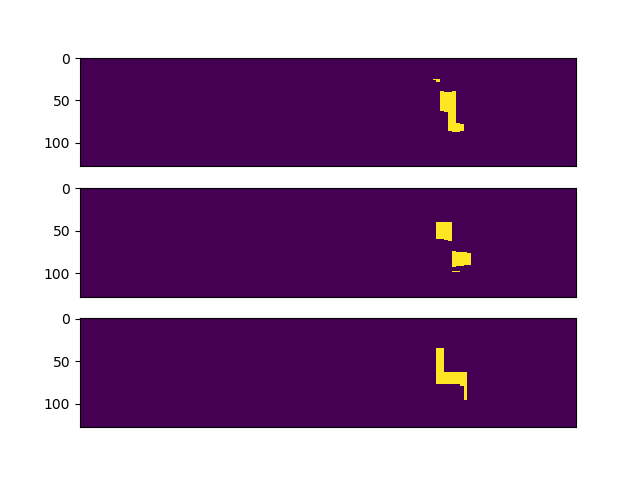

([], <a list of 0 Text xticklabel objects>)

In [22]:
one_case = np.random.choice(testing.keys(),1)[0]
plt.figure()
plt.subplot(311)
plt.imshow(testing[one_case]['masks'][32.128].reshape(128,128),aspect='auto');plt.xticks([])
plt.subplot(312)
plt.imshow(testing[one_case]['masks'][64.128].reshape(128,128),aspect='auto');plt.xticks([])
plt.subplot(313)
plt.imshow(testing[one_case]['masks'][96.128].reshape(128,128),aspect='auto');plt.xticks([])

In [ ]:
### begin to put the files into pickles so that we have an intermediate step of the dataset
with open("sound_spec_mask/round_2/test_r2_w_resized.pkl", "wb") as test_file:
    pickle.dump(testing, test_file)

with open(r'sound_spec_mask/round_2/training_r2_w_resized.pkl','wb') as train_file:
    pickle.dump(training, train_file)

with open(r'sound_spec_mask/round_2/validation_r2_w_resized.pkl','wb') as validn_file:
    pickle.dump(validation, validn_file)


In [23]:
# also extract all of the masks and images into dictionaries, and store the uuid with them so that they can be accessed 
# later 

def format_into_network_input(data_dict,mask_or_spec='masks'):
    names = []
    num_samples = 3 * len(data_dict.keys())
    image_tensor = np.zeros((num_samples,128,128,1))
    i = 0 
    for each_sample in data_dict.keys():
        for each_resln in [32.128, 64.128, 96.128]:
            this_img_name = each_sample + '_'+str(each_resln)
            names.append(this_img_name)
            image_tensor[i] = data_dict[each_sample][mask_or_spec][each_resln]
            i += 1 
    return(names, image_tensor)
            
        
    
    

In [27]:
training_uids, training_specs = format_into_network_input(training, 'specgms')
training_uids, training_masks = format_into_network_input(training, 'masks')

validation_uids, validation_specs = format_into_network_input(validation, 'specgms')
validation_uids, validation_masks = format_into_network_input(validation, 'masks')

testing_uids, testing_specs = format_into_network_input(testing, 'specgms')
testing_uids, testing_masks = format_into_network_input(testing, 'masks')

In [29]:
# save the data into a simple dictionary format 
required_data = {}
required_data['training'] = {'images':training_specs, 'masks':training_masks, 'uids': training_uids}
required_data['validation'] = {'images':validation_specs, 'masks':validation_masks, 'uids': validation_uids}
required_data['testing'] = {'images':testing_specs, 'masks':testing_masks, 'uids': testing_uids}

with open('sound_spec_mask/NN_required_data.pkl','wb') as req_data:
    pickle.dump(required_data, req_data, )


So now, having made the data - it's off to creating the network and training it. 